# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
## Test <a href=http://www.ramp.studio/problems/iris>RAMP on iris</a> 

<i> Balázs Kégl (LAL/CNRS)</i>

## Introduction

Iris is a small standard multi-class classification data set from the <a href="http://archive.ics.uci.edu/ml/datasets/Iris">UCI Machine Learning Repository</a>.

In [2]:
from __future__ import print_function

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Fetch the data and load it in pandas

In [3]:
local_filename = 'data/train.csv'

# Open file and print the first 3 lines
with open(local_filename) as fid:
    for line in fid.readlines()[:3]:
        print(line)

sepal length,sepal width,petal length,petal width,species

5.0,3.5,1.6,0.6,setosa

6.1,2.8,4.7,1.2,versicolor



In [4]:
data = pd.read_csv(local_filename)

In [5]:
data.head()

,sepal length,sepal width,petal length,petal width,species
0,5.0,3.5,1.6,0.6,setosa
1,6.1,2.8,4.7,1.2,versicolor
2,6.8,2.8,4.8,1.4,versicolor
3,6.7,3.1,5.6,2.4,virginica
4,5.0,2.0,3.5,1.0,versicolor


In [6]:
data.shape

(96, 5)

In [7]:
data.describe()

,sepal length,sepal width,petal length,petal width
count,96.000000,96.000000,96.000000,96.000000
mean,5.801042,3.028125,3.742708,1.214583
std,0.846354,0.430349,1.752397,0.783377
min,4.300000,2.000000,1.000000,0.100000
25%,5.000000,2.800000,1.600000,0.300000
50%,5.700000,3.000000,4.450000,1.300000
75%,6.500000,3.300000,5.125000,1.825000
max,7.700000,4.200000,6.700000,2.500000


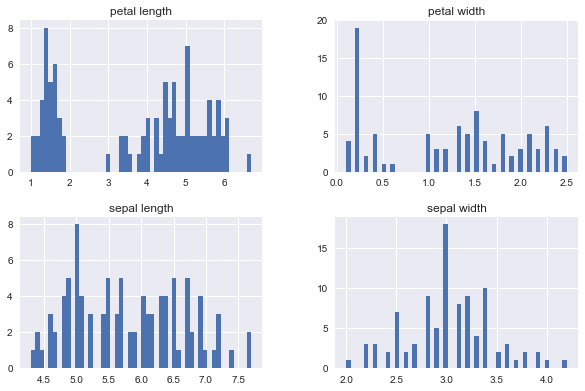

In [8]:
data.hist(figsize=(10, 10), bins=50, layout=(3, 2));

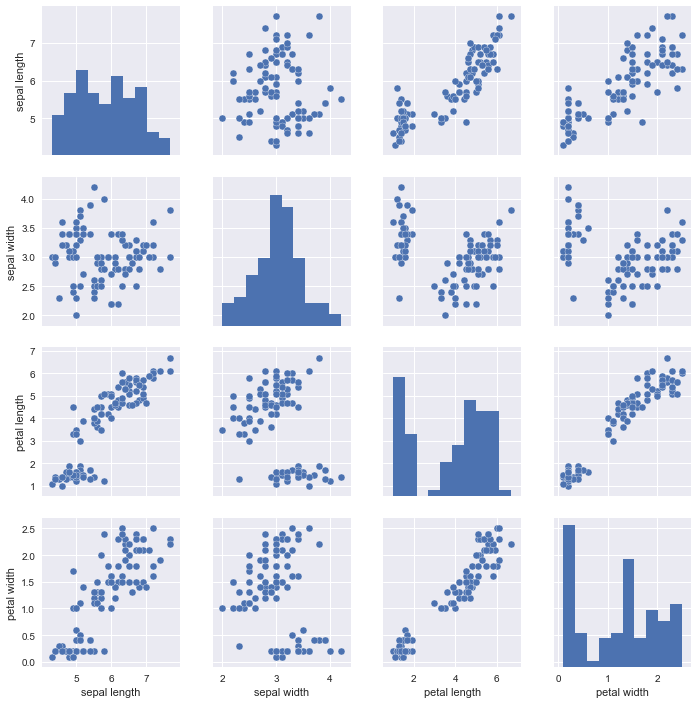

In [9]:
sns.pairplot(data);

## Building predictive models

The initial classifier in your sandbox. The following cell is *not* executed in the notebook, rather it saves its content in the file in the first line, so you can edit your submission before running the local test below and submitting it at the RAMP site.

In [69]:
%%file submissions/starting_kit/classifier.py
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
import numpy as np



class Classifier(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        
        # ****************************
        # MLP
        # ****************************

        # mean centre and reduce the data
        Xtrain = scale(X)
        
        # define and train MLP
        self.clf_MLP =  MLPClassifier(hidden_layer_sizes=(50,),activation='tanh',solver='sgd',
                                      learning_rate='adaptive',alpha=0.001, max_iter=100000, early_stopping=True)
        
        # ****************************
        # Decision Tree
        # ****************************

        # mean centre and reduce the data
        Xtrain = scale(X)
        
        # create model and define sequences of parameters to try
        dtmodel = DecisionTreeClassifier(presort=True)
        criterion=['gini', 'entropy']
        max_depth=[2, 3, 4, 5, 6, 7]
        param_grid = dict(max_depth=max_depth, criterion=criterion)
        strat = StratifiedShuffleSplit(n_splits=5, test_size=0.3)
        
        # find the combination of parameters that produces the lowest error, and fit this model
        DT_cv = GridSearchCV(dtmodel, param_grid=param_grid, cv=strat)
        DT_cv.fit(Xtrain,y)

        # show the best parameters selected for the DT model
        print("Parameters, accuracy and score from Kernel:")
        print("")
        print("   Tuned Parameters: {}".format(DT_cv.best_params_))
        print("   Tuned Accuracy: {}".format(DT_cv.best_score_))

        # train the model with the best parameters
        DT_max_depth = DT_cv.best_params_["max_depth"]
        DT_criterion = DT_cv.best_params_["criterion"]
        self.clf_DT = DecisionTreeClassifier(max_depth=DT_max_depth, criterion=DT_criterion,
                                             random_state=0, presort=True)
        
        
        # ****************************
        # K-nearest neigbours (KNN) with gridsearch
        # ****************************
        # mean centre and reduce the data
        Xtrain = scale(X)
        
        # create model and define sequences of parameters to try
        knnmodel = KNeighborsClassifier(n_jobs=-1)
        n_neighbors=[1, 2, 3, 4, 5]
        p=[1, 2, 3, 4, 5]
        metric=['minkowski']
        weights=['uniform', 'distance']
        param_grid = dict(n_neighbors=n_neighbors, p=p, weights=weights, metric=metric)
        strat = StratifiedShuffleSplit(n_splits=5, test_size=0.3)

        # find the combination of parameters that produces the lowest error, and fit this model
        KNN_cv = GridSearchCV(knnmodel, param_grid=param_grid, cv=strat)
        KNN_cv.fit(Xtrain,y)

        # show the best parameters selected for the KNN model
        print("Parameters, accuracy and score from Kernel:")
        print("")
        print("   Tuned Parameters: {}".format(KNN_cv.best_params_))
        print("   Tuned Accuracy: {}".format(KNN_cv.best_score_))

        # train the model with the best parameters
        KNN_metric = KNN_cv.best_params_["metric"]
        KNN_n_neighbors = KNN_cv.best_params_["n_neighbors"]
        KNN_p = KNN_cv.best_params_["p"]
        KNN_weights = KNN_cv.best_params_["weights"]
        self.clf_KNN = KNeighborsClassifier(n_neighbors=KNN_n_neighbors, p=KNN_p, weights=KNN_weights, 
                                        metric=KNN_metric, n_jobs=-1)
        # self.clf_KNN.fit(Xtrain,y)
        # print("   Model Score: {}".format(self.clf_KNN.score(Xtrain,y)))

        
        # ****************************
        # Support Vector Machine (SVM) with gridsearch
        # ****************************
        # mean centre and reduce the data
        Xtrain = scale(X)
        
        # create model and define sequences of parameters to try
        svmmodel = svm.SVC(probability=True)
        C_range = np.logspace(-2, 10, 13)
        gamma_range = np.logspace(-9, 3, 13)
        kernel=['rbf', 'poly', 'sigmoid']
        degree=[3, 4, 5]
        decision_function_shape=['ovr', 'ovo']
        param_grid = dict(kernel=kernel, degree=degree, gamma=gamma_range, C=C_range, decision_function_shape=decision_function_shape)
        strat = StratifiedShuffleSplit(n_splits=5, test_size=0.1)

        # find the combination of parameters that produces the lowest error, and fit this model
        SVM_cv = GridSearchCV(svmmodel, param_grid=param_grid, cv=strat)
        SVM_cv.fit(Xtrain,y)

        # show the best parameters selected for the SVM model
        print("Parameters, accuracy and score from Kernel:")
        print("")
        print("   Tuned Parameters: {}".format(SVM_cv.best_params_))
        print("   Tuned Accuracy: {}".format(SVM_cv.best_score_))

        # train the model with the best parameters
        SVM_kernel = SVM_cv.best_params_["kernel"]
        SVM_gamma = SVM_cv.best_params_["gamma"]
        SVM_C = SVM_cv.best_params_["C"]
        SVM_degree = SVM_cv.best_params_["degree"]
        SVM_decision_function_shape = SVM_cv.best_params_["decision_function_shape"]
        self.clf_SVM = svm.SVC(kernel = SVM_kernel, gamma = SVM_gamma, C = SVM_C, degree=SVM_degree, 
                           decision_function_shape=SVM_decision_function_shape, probability=True)

        # ****************************
        # Combine all 4 models with VotingClassifier
        # ****************************
        # Training classifiers
        self.eclf = VotingClassifier(estimators=[('mlp', self.clf_MLP), ('dtree', self.clf_DT), ('knn', self.clf_KNN), ('svc', self.clf_SVM)],
                             voting='hard', weights=[10, 1, 1, 1])
        self.eclf.fit(Xtrain, y)


    # seems this method isn't used at all
    def predict(self, X):

        return self.clf.predict(X)

    
    def predict_proba(self, X):
        # mean centre and reduce the data
        Xtest = scale(X)
        
        # get class predictions from pre-trained VotingClassifier
        Z = self.eclf.predict(Xtest)
        
        # convert Z to integer categorical
        zlist = list(Z)
        zlistnew = [0 if x == 'setosa' else 1 if x == 'versicolor' else 2 if x == 'virginica' else None for x in zlist]
        zarray = np.array(zlistnew).astype(int).reshape(-1, 1)

        # convert integers to one-hot encoding, to be interpreted as probabilities
        enc = OneHotEncoder(sparse=False, handle_unknown='error')
        enc.fit(zarray)
        pred_onehot = enc.transform(zarray)
    
        return pred_onehot



Overwriting submissions/starting_kit/classifier.py


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit).

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python file `classifier.py` is in the  [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit) folder, and the data `train.csv` and `test.csv` are in [`data`](http://localhost:8890/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [70]:
!ramp_test_submission

Testing Iris classification
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
Parameters, accuracy and score from Kernel:

   Tuned Parameters: {'criterion': 'gini', 'max_depth': 2}
   Tuned Accuracy: 0.9739130434782609
Parameters, accuracy and score from Kernel:

   Tuned Parameters: {'metric': 'minkowski', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
   Tuned Accuracy: 0.9739130434782609
Parameters, accuracy and score from Kernel:

   Tuned Parameters: {'C': 0.01, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 10.0, 'kernel': 'poly'}
   Tuned Accuracy: 0.975
/Users/carl/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
	score   acc  error    nll  f1_70
	train  0.45   0.55  19.09   0.00
	valid  0.50   0.50  17.27   0.33
	test   0.42   0.

#### Alternatively, load and execute `rampwf.utils.testing.py`, and call `assert_submission`. This may be useful if you would like to understand how we instantiate the workflow, the scores, the data connectors, and the cross validation scheme defined in [`problem.py`](problem.py), and how we insert and train/test your submission.

In [176]:
# %load https://raw.githubusercontent.com/paris-saclay-cds/ramp-workflow/master/rampwf/utils/testing.py

"""Provide utils to test ramp-kits."""
from __future__ import print_function

import os
import imp
from subprocess import call
from os.path import join, abspath
from collections import OrderedDict

import pandas as pd
import numpy as np
from colored import stylize, fg, attr
import cloudpickle as pickle
from .combine import get_score_cv_bags

fg_colors = {
    'official_train': 'light_green',
    'official_valid': 'light_blue',
    'official_test': 'red',
    'train': 'dark_sea_green_3b',
    'valid': 'light_slate_blue',
    'test': 'pink_1',
    'title': 'gold_3b',
    'warning': 'grey_46',
}


def _print_title(str):
    print(stylize(str, fg(fg_colors['title']) + attr('bold')))


def _print_warning(str):
    print(stylize(str, fg(fg_colors['warning'])))


def _delete_line_from_file(f_name, line_to_delete):
    with open(f_name, "r+") as f:
        lines = f.readlines()
        f.seek(0)
        for line in lines:
            if line != line_to_delete:
                f.write(line)
        f.truncate()


def execute_notebook(ramp_kit_dir='.'):
    problem_name = abspath(ramp_kit_dir).split('/')[-1]
    print('Testing if the notebook can be executed')
    call(
        'jupyter nbconvert --execute {}/{}_starting_kit.ipynb '.format(
            ramp_kit_dir, problem_name) +
        '--ExecutePreprocessor.kernel_name=$IPYTHON_KERNEL ' +
        '--ExecutePreprocessor.timeout=600', shell=True)


def convert_notebook(ramp_kit_dir='.'):
    problem_name = abspath(ramp_kit_dir).split('/')[-1]
    print('Testing if the notebook can be converted to html')
    call('jupyter nbconvert --to html {}/{}_starting_kit.ipynb'.format(
        ramp_kit_dir, problem_name), shell=True)
    _delete_line_from_file(
        '{}/{}_starting_kit.html'.format(ramp_kit_dir, problem_name),
        '<link rel="stylesheet" href="custom.css">\n')


def assert_notebook(ramp_kit_dir='.'):
    print('----------------------------')
    convert_notebook(ramp_kit_dir)
    execute_notebook(ramp_kit_dir)


def assert_read_problem(ramp_kit_dir='.'):
    # giving a random name to the module so it passes looped tests
    module_name = str(int(1000000000 * np.random.rand()))
    problem = imp.load_source(module_name, join(ramp_kit_dir, 'problem.py'))
    return problem


def assert_title(ramp_kit_dir='.'):
    problem = assert_read_problem(ramp_kit_dir)
    _print_title('Testing {}'.format(problem.problem_title))


def assert_data(ramp_kit_dir='.', ramp_data_dir='.'):
    problem = assert_read_problem(ramp_kit_dir)
    _print_title('Reading train and test files from {}/data ...'.format(
        ramp_data_dir))
    X_train, y_train = problem.get_train_data(path=ramp_data_dir)
    X_test, y_test = problem.get_test_data(path=ramp_data_dir)
    return X_train, y_train, X_test, y_test


def assert_cv(ramp_kit_dir='.', ramp_data_dir='.'):
    problem = assert_read_problem(ramp_kit_dir)
    X_train, y_train = problem.get_train_data(path=ramp_data_dir)
    _print_title('Reading cv ...')
    cv = list(problem.get_cv(X_train, y_train))
    return cv


def assert_score_types(ramp_kit_dir='.'):
    problem = assert_read_problem(ramp_kit_dir)
    score_types = problem.score_types
    return score_types


def _mean_score_matrix(df_scores_list, score_types):
    u"""Construct a mean ± std score dataframe from a list of score dataframes.

    Parameters
    ----------
    df_scores_list : list of pd.DataFrame
        a list of score data frames to average
    score_types : list of score types
        a list of score types to use

    Returns
    -------
    df_scores : the mean ± std score dataframe
    """
    scores = np.array([df_scores.values for df_scores in df_scores_list])
    meanss = scores.mean(axis=0)
    stdss = scores.std(axis=0)
    # we use unicode no break space so split in _print_df_scores works
    strs = np.array([[
        u'{val}\u00A0±\u00A0{std}'.format(
            val=round(mean, score_type.precision),
            std=round(std, score_type.precision + 1))
        for mean, std, score_type in zip(means, stds, score_types)]
        for means, stds in zip(meanss, stdss)])
    df_scores = pd.DataFrame(
        strs, columns=df_scores_list[0].columns, index=df_scores_list[0].index)
    return df_scores


def _score_matrix_from_scores(score_types, steps, scoress):
    """Construct a score dataframe from a matrix of scores.

    Parameters
    ----------
    score_types : list of score types
        a list of score types to use, score_type.name serves as column index
    steps : a list of strings
        subset of ['train', 'valid', 'test'], serves as row index

    Returns
    -------
    df_scores : the score dataframe
    """
    results = []
    for step, scores in zip(steps, scoress):
        for score_type, score in zip(score_types, scores):
            results.append(
                {'step': str(step), 'score': score_type.name, 'value': score})
    df_scores = pd.DataFrame(results)
    df_scores = df_scores.set_index(['step', 'score'])['value']
    df_scores = df_scores.unstack()
    return df_scores


def _score_matrix(score_types, ground_truth, predictions):
    """Construct a score dataframe by scoring predictions against ground truth.

    Parameters
    ----------
    score_types : list of score types
        a list of score types to use, score_type.name serves as column index
    ground_truth : dict of Predictions
        the ground truth data
    predictions : dict of Predictions
        the predicted data

    Returns
    -------
    df_scores : pd.DataFrame
        table of scores (rows = train/valid/test steps, columns = scores)
    """
    if set(ground_truth.keys()) != set(predictions.keys()):
        raise ValueError(('Predictions and ground truth steps '
                          'do not match:\n'
                          ' * predictions = {} \n'
                          ' * ground_truth = {} ')
                         .format(set(predictions.keys()),
                                 set(ground_truth.keys())))
    steps = ground_truth.keys()
    scoress = [[
        score_type.score_function(ground_truth[step], predictions[step])
        for score_type in score_types] for step in ground_truth]
    return _score_matrix_from_scores(score_types, steps, scoress)


def _round_df_scores(df_scores, score_types):
    """Round scores to the precision set in the score type.

    Parameters
    ----------
    df_scores : pd.DataFrame
        the score dataframe
    score_types : list of score types

    Returns
    -------
    df_scores : the dataframe with rounded scores
    """
    df_scores_copy = df_scores.copy()
    for column, score_type in zip(df_scores_copy, score_types):
        df_scores_copy[column] = [round(score, score_type.precision)
                                  for score in df_scores_copy[column]]
    return df_scores_copy


def _print_df_scores(df_scores, score_types, indent=''):
    """Pretty print the scores dataframe.

    Parameters
    ----------
    df_scores : pd.DataFrame
        the score dataframe
    score_types : list of score types
        a list of score types to use
    indent : str, default=''
        indentation if needed
    """
    try:
        # try to re-order columns/rows in the printed array
        # we may not have all train, valid, test, so need to select
        index_order = np.array(['train', 'valid', 'test'])
        ordered_index = index_order[np.isin(index_order, df_scores.index)]
        df_scores = df_scores.loc[
            ordered_index, [score_type.name for score_type in score_types]]
    except Exception:
        _print_warning("Couldn't re-order the score matrix..")
    with pd.option_context("display.width", 160):
        df_repr = repr(df_scores)
    df_repr_out = []
    for line, color_key in zip(df_repr.splitlines(),
                               [None, None] +
                               list(df_scores.index.values)):
        if line.strip() == 'step':
            continue
        if color_key is None:
            # table header
            line = stylize(line, fg(fg_colors['title']) + attr('bold'))
        if color_key is not None:
            tokens = line.split()
            tokens_bak = tokens[:]
            if 'official_' + color_key in fg_colors:
                # line label and official score bold & bright
                label_color = fg(fg_colors['official_' + color_key])
                tokens[0] = stylize(tokens[0], label_color + attr('bold'))
                tokens[1] = stylize(tokens[1], label_color + attr('bold'))
            if color_key in fg_colors:
                # other scores pale
                tokens[2:] = [stylize(token, fg(fg_colors[color_key]))
                              for token in tokens[2:]]
            for token_from, token_to in zip(tokens_bak, tokens):
                line = line.replace(token_from, token_to)
        line = indent + line
        df_repr_out.append(line)
    print('\n'.join(df_repr_out))


def _save_y_pred(problem, y_pred, data_path='.', output_path='.',
                 suffix='test'):
    """Save a prediction vector in file.

    If problem.save_y_pred is implemented, y_pred is passed to it. Otherwise,
    np.savetxt is used on y_pred. If it crashes, a warning it raised. The file
    is (typically) in
    submissions/<submission_name>/training_output/y_pred_<suffix>.csv or
    submissions/<submission_name>/training_output/fold_<i>/y_pred_<suffix>.csv.

    Parameters
    ----------
    problem : a problem object
        loaded from problem.py, may implement save_y_pred
    y_pred : a prediction vector
        a vector of predictions to be saved
    data_path : str, (default='.')
        the directory of the ramp-kit to be tested for submission, maybe
        needed by problem.save_y_pred for, e.g., merging with an index vector
    output_path : str, (default='.')
        the directory where (typically) y_pred_<suffix>.csv will be saved
    suffix : str, (default='test')
        suffix in (typically) y_pred_<suffix>.csv, can be used in
        problem.save_y_pred to, e.g., save only test predictions
    """
    try:
        # We try using custom made problem.save_y_pred
        # it may need to re-read the data, e.g., for ids, so we send
        # it the data path
        problem.save_y_pred(y_pred, data_path, output_path, suffix)
    except AttributeError:
        # We fall back to numpy save
        try:
            y_pred_f_name = join(output_path, 'y_pred_{}.csv'.format(suffix))
            np.savetxt(y_pred_f_name, y_pred)
        except Exception as e:
            _print_warning(
                "Warning: model can't be saved.\n{}\n".format(e) +
                'Consider implementing custom save_y_pred in problem.py\n' +
                'See https://github.com/ramp-kits/kaggle_seguro/' +
                'blob/master/problem.py')


def _pickle_model(fold_output_path, trained_workflow, model_name='model.pkl'):
    """Pickle and reload trained workflow.

    If workflow can't be pickled, print warning and return origina' workflow.

    Parameters
    ----------
    fold_output_path : str
        the path into which the model will be pickled
    trained_workflow : a rampwf.workflow
        the workflow to be pickled
    model_name : str (default='model.pkl')
        the file name of the pickled workflow
    Returns
    -------
    trained_workflow : a rampwf.workflow
        either the input workflow or the pickled and reloaded workflow
    """
    try:
        model_file = join(fold_output_path, model_name)
        with open(model_file, 'wb') as pickle_file:
            pickle.dump(trained_workflow, pickle_file)
        with open(model_file, 'r') as pickle_file:
            trained_workflow = pickle.load(pickle_file)
    except Exception as e:
        _print_warning("Warning: model can't be pickled.")
        _print_warning(e)
    return trained_workflow


def _train_test_submission(problem, module_path, X_train, y_train, X_test,
                           is_pickle, output_path,
                           model_name='model.pkl', train_is=None):
    """Train and test submission, on cv fold if train_is not none.

    Parameters
    ----------
    problem : problem object
        imp.loaded from problem.py
    module_path : str
        the path of the submission, typically submissions/<submission_name>
    X_train : a list of training instances
        returned by problem.get_train_data
    y_train : a list of training ground truth
        returned by problem.get_train_data
    X_train : a list of testing instances
        returned by problem.get_test_data
    is_pickle : boolean
        True if the model should be pickled
    output_path : str
        the path into which the model will be pickled
    model_name : str (default='model.pkl')
        the file name of the pickled workflow
    train_is : a list of integers (default=None)
        training indices from the cross-validation fold, if None, train
        on full set
    Returns
    -------
    y_pred_train : a list of predictions
        on the training (train_train and train_valid) set
    y_pred_test : a list of predictions
        on the test set
    """
    trained_workflow = problem.workflow.train_submission(
        module_path, X_train, y_train, train_is=train_is)
    if is_pickle:
        trained_workflow = _pickle_model(
            output_path, trained_workflow, model_name)

    y_pred_train = problem.workflow.test_submission(
        trained_workflow, X_train)
    y_pred_test = problem.workflow.test_submission(
        trained_workflow, X_test)
    return y_pred_train, y_pred_test


def _run_submission_on_cv_fold(problem, module_path, X_train, y_train,
                               X_test, y_test, score_types,
                               is_pickle, save_y_preds, fold_output_path,
                               fold, ramp_data_dir):
    """Run submission, compute and return predictions and scores on cv.

    Parameters
    ----------
    problem : problem object
        imp.loaded from problem.py
    module_path : str
        the path of the submission, typically submissions/<submission_name>
    X_train : a list of training instances
        returned by problem.get_train_data
    y_train : a list of training ground truth
        returned by problem.get_train_data
    X_train : a list of testing instances
        returned by problem.get_test_data
    y_test : a list of testing ground truth
        returned by problem.get_test_data
    score_types : a list of score types
        problem.score_types
    is_pickle : boolean
        True if the model should be pickled
    save_y_preds : boolean
        True if predictions should be written in files
    fold_output_path : str
        the path into which the model will be pickled
    fold : pair of lists of integers
        (train_is, valid_is) generated by problem.get_cv
    ramp_data_dir : str
        the directory of the data
    Returns
    -------
    predictions_train_valid : instance of Predictions
        on the validation set
    predictions_test : instance of Predictions
        on the test set
    df_scores : pd.DataFrame
        table of scores (rows = train/valid/test steps, columns = scores)
    """
    train_is, valid_is = fold
    y_pred_train, y_pred_test = _train_test_submission(
        problem, module_path, X_train, y_train, X_test, is_pickle,
        fold_output_path, train_is=train_is)
    predictions_train_train = problem.Predictions(
        y_pred=y_pred_train[train_is])
    ground_truth_train_train = problem.Predictions(
        y_true=y_train[train_is])
    predictions_train_valid = problem.Predictions(
        y_pred=y_pred_train[valid_is])
    ground_truth_train_valid = problem.Predictions(
        y_true=y_train[valid_is])
    predictions_test = problem.Predictions(y_pred=y_pred_test)
    ground_truth_test = problem.Predictions(y_true=y_test)

    if save_y_preds:
        _save_y_pred(
            problem, y_pred_train, data_path=ramp_data_dir,
            output_path=fold_output_path, suffix='train')
        _save_y_pred(
            problem, y_pred_test, data_path=ramp_data_dir,
            output_path=fold_output_path, suffix='test')

    df_scores = _score_matrix(
        score_types,
        ground_truth=OrderedDict([('train', ground_truth_train_train),
                                  ('valid', ground_truth_train_valid),
                                  ('test', ground_truth_test)]),
        predictions=OrderedDict([('train', predictions_train_train),
                                 ('valid', predictions_train_valid),
                                 ('test', predictions_test)]),
    )
    return predictions_train_valid, predictions_test, df_scores


def _run_submission_on_full_train(problem, module_path, X_train, y_train,
                                  X_test, y_test, score_types,
                                  is_pickle, save_y_preds, output_path,
                                  ramp_data_dir):
    """Run submission, compute predictions, and print scores on full train.

    Parameters
    ----------
    problem : problem object
        imp.loaded from problem.py
    module_path : str
        the path of the submission, typically submissions/<submission_name>
    X_train : a list of training instances
        returned by problem.get_train_data
    y_train : a list of training ground truth
        returned by problem.get_train_data
    X_train : a list of testing instances
        returned by problem.get_test_data
    y_test : a list of testing ground truth
        returned by problem.get_test_data
    score_types : a list of score types
        problem.score_types
    is_pickle : boolean
        True if the model should be pickled
    save_y_preds : boolean
        True if predictions should be written in files
    output_path : str
        the path into which the model will be pickled
    ramp_data_dir : str
        the directory of the data
    """
    y_pred_train, y_pred_test = _train_test_submission(
        problem, module_path, X_train, y_train, X_test, is_pickle,
        output_path, model_name='retrained_model.pkl')
    predictions_train = problem.Predictions(y_pred=y_pred_train)
    ground_truth_train = problem.Predictions(y_true=y_train)
    predictions_test = problem.Predictions(y_pred=y_pred_test)
    ground_truth_test = problem.Predictions(y_true=y_test)

    df_scores = _score_matrix(
        score_types,
        ground_truth=OrderedDict([('train', ground_truth_train),
                                  ('test', ground_truth_test)]),
        predictions=OrderedDict([('train', predictions_train),
                                 ('test', predictions_test)]),
    )
    df_scores_rounded = _round_df_scores(df_scores, score_types)
    _print_df_scores(df_scores_rounded, score_types, indent='\t')

    if save_y_preds:
        _save_y_pred(
            problem, y_pred_train, data_path=ramp_data_dir,
            output_path=output_path, suffix='retrain_train')
        _save_y_pred(
            problem, y_pred_test, data_path=ramp_data_dir,
            output_path=output_path, suffix='retrain_test')


def assert_submission(ramp_kit_dir='.', ramp_data_dir='.',
                      submission='starting_kit', is_pickle=False,
                      save_y_preds=False, retrain=False):
    """Helper to test a submission from a ramp-kit.

    Parameters
    ----------
    ramp_kit_dir : str, (default='.')
        the directory of the ramp-kit to be tested for submission

    ramp_data_dir : str, (default='.')
        the directory of the data

    submission_name : str, (default='starting_kit')
        the name of the submission to be tested
    """
    problem = assert_read_problem(ramp_kit_dir)
    assert_title(ramp_kit_dir)
    X_train, y_train, X_test, y_test = assert_data(ramp_kit_dir, ramp_data_dir)
    cv = assert_cv(ramp_kit_dir, ramp_data_dir)
    score_types = assert_score_types(ramp_kit_dir)

    module_path = join(ramp_kit_dir, 'submissions', submission)
    _print_title('Training {} ...'.format(module_path))

    training_output_path = ''
    if is_pickle or save_y_preds:
        # creating submissions/<submission>/training_output dir
        training_output_path = join(module_path, 'training_output')
        if not os.path.exists(training_output_path):
            os.mkdir(training_output_path)

    # saving predictions for CV bagging after the CV loop
    predictions_train_valid_list = []
    predictions_test_list = []
    df_scores_list = []

    for fold_i, fold in enumerate(cv):
        fold_output_path = ''
        if is_pickle or save_y_preds:
            # creating submissions/<submission>/training_output/fold_<i> dir
            fold_output_path = join(
                training_output_path, 'fold_{}'.format(fold_i))
            if not os.path.exists(fold_output_path):
                os.mkdir(fold_output_path)
        _print_title('CV fold {}'.format(fold_i))

        predictions_train_valid, predictions_test, df_scores =\
            _run_submission_on_cv_fold(
                problem, module_path, X_train, y_train, X_test, y_test,
                score_types, is_pickle, save_y_preds, fold_output_path,
                fold, ramp_data_dir)
        df_scores_rounded = _round_df_scores(df_scores, score_types)
        _print_df_scores(df_scores_rounded, score_types, indent='\t')

        # saving predictions for CV bagging after the CV loop
        df_scores_list.append(df_scores)
        predictions_train_valid_list.append(predictions_train_valid)
        predictions_test_list.append(predictions_test)

    _print_title('----------------------------')
    _print_title('Mean CV scores')
    _print_title('----------------------------')
    df_mean_scores = _mean_score_matrix(df_scores_list, score_types)
    _print_df_scores(df_mean_scores, score_types, indent='\t')

    if retrain:
        # We retrain on the full training set
        _print_title('----------------------------')
        _print_title('Retrain scores')
        _print_title('----------------------------')
        _run_submission_on_full_train(
            problem, module_path, X_train, y_train, X_test, y_test,
            score_types, is_pickle, save_y_preds, training_output_path,
            ramp_data_dir)

    _print_title('----------------------------')
    _print_title('Bagged scores')
    _print_title('----------------------------')
    valid_is_list = [valid_is for (train_is, valid_is) in cv]
    ground_truths_train = problem.Predictions(y_true=y_train)
    ground_truths_test = problem.Predictions(y_true=y_test)
    score_type = score_types[0]
    bagged_train_valid_predictions, bagged_train_valid_scores =\
        get_score_cv_bags(
            problem.Predictions, score_type, predictions_train_valid_list,
            ground_truths_train, test_is_list=valid_is_list)
    bagged_test_predictions, bagged_test_scores = get_score_cv_bags(
        problem.Predictions, score_type, predictions_test_list,
        ground_truths_test)

    df_scores = _score_matrix_from_scores(
        score_types[0:1], ['valid', 'test'],
        [[bagged_train_valid_scores[-1]], [bagged_test_scores[-1]]])
    df_scores_rounded = _round_df_scores(df_scores, score_types[0:1])
    _print_df_scores(df_scores_rounded, score_types[0:1], indent='\t')

    if save_y_preds:
        # y_pred_bagged_train.csv contains _out of sample_ (validation)
        # predictions, but not for all points (contains nans)
        _save_y_pred(
            problem, bagged_train_valid_predictions.y_pred,
            data_path=ramp_data_dir, output_path=training_output_path,
            suffix='bagged_train')
        _save_y_pred(
            problem, bagged_test_predictions.y_pred, data_path=ramp_data_dir,
            output_path=training_output_path, suffix='bagged_test')
        # also save the partial combined scores (CV bagging learning curves)
        bagged_train_valid_scores_f_name = join(
            training_output_path, 'bagged_train_valid_scores.csv')
        np.savetxt(bagged_train_valid_scores_f_name, bagged_train_valid_scores)
        bagged_test_scores_f_name = join(
            training_output_path, 'bagged_test_scores.csv')
        np.savetxt(bagged_test_scores_f_name, bagged_test_scores)


ModuleNotFoundError: No module named '__main__.combine'; '__main__' is not a package

In [18]:
# assert_submission()

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good classifier, you can submit it to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [iris_test](http://www.ramp.studio/events/iris_test) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/iris_test/sandbox) and copy-paste (or upload) [`classifier.py`](http://localhost:8890/edit/submissions/starting_kit/classifier.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/iris_test/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/iris_test/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/iris_test/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train acc = 0.62 ± 0.033
train err = 0.38 ± 0.033
train nll = 1.01 ± 0.378
train f1_70 = 0.5 ± 0.167
valid acc = 0.63 ± 0.06
valid err = 0.38 ± 0.06
valid nll = 1.41 ± 1.115
valid f1_70 = 0.5 ± 0.167
test acc = 0.55 ± 0.084
test err = 0.45 ± 0.084
test nll = 1.31 ± 0.858
test f1_70 = 0.4 ± 0.133
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/iris_test/leaderboard)) is accuracy ("acc"), so the line that is relevant in the output of `ramp_test_submission` is `valid acc = 0.63 ± 0.06`. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=iris notebook).